# 模型选择、欠拟合和过拟合

## 多项式回归

### 通过多项式拟合来探索这些概念


In [1]:
# 导入工具包
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据集

#### 使用以下三阶多项式来生成训练和测试数据的标签：]

- $𝑦=5+1.2𝑥−3.4\frac{𝑥^2}{2!}+5.6\frac{𝑥^3}{3!}+𝜖$ ,where $𝜖∼\mathcal{N}(0,0.12)$

- 噪声项 𝜖 服从均值为 0 且标准差为 0.1 的正态分布。 
- 在优化的过程中，我们通常希望避免非常大的梯度值或损失值。 
- 这就是我们将特征从 $𝑥^𝑖$ 调整为 $\frac{𝑥^𝑖}{𝑖!}$ 的原因， 这样可以避免很大的 𝑖带来的特别大的指数值。

In [2]:
max_degree = 20   # 多项式的最大阶数
n_train, n_test = 100, 100   # 训练和测试数据集大小,都是100个。测试既是验证
true_w = np.zeros(max_degree)   # 真实的 w 也是长为 20
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) # 剩下全是0，噪音

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

### 查看一下前2个样本

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.0956],
         [-0.2624]]),
 tensor([[ 1.0000e+00,  1.0956e+00,  6.0017e-01,  2.1918e-01,  6.0034e-02,
           1.3155e-02,  2.4020e-03,  3.7595e-04,  5.1487e-05,  6.2677e-06,
           6.8669e-07,  6.8394e-08,  6.2444e-09,  5.2626e-10,  4.1183e-11,
           3.0080e-12,  2.0597e-13,  1.3274e-14,  8.0797e-16,  4.6590e-17],
         [ 1.0000e+00, -2.6240e-01,  3.4427e-02, -3.0112e-03,  1.9754e-04,
          -1.0367e-05,  4.5337e-07, -1.6995e-08,  5.5743e-10, -1.6252e-11,
           4.2646e-13, -1.0173e-14,  2.2245e-16, -4.4901e-18,  8.4157e-20,
          -1.4722e-21,  2.4144e-23, -3.7267e-25,  5.4327e-27, -7.5029e-29]]),
 tensor([5.5728, 4.3386]))

### 对模型进行训练和测试

#### 实现一个函数来评估模型在给定数据集上的损失

In [4]:
def evaluate_loss(net, data_iter, loss): 
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)    # 输出
        y = y.reshape(out.shape)  # 把yreshape成输出一样维度
        l = loss(out, y)
        metric.add(l.sum(), l.numel())  # 整个数据集上
    return metric[0] / metric[1]

### 定义训练函数

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')   # MSE loss
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))   # 定义一个单层线性回归网络
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 三阶多项式函数拟合(正态)

weight: [[ 5.031985   1.2056631 -3.4289277  5.601041 ]]


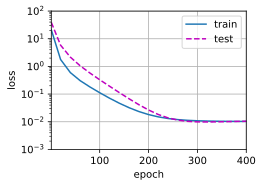

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

- 两个重要点
    - train和test loss最后达到的值
    - train和test 之间的gap

### 线性函数拟合(欠拟合)

weight: [[3.6402047 3.4346836]]


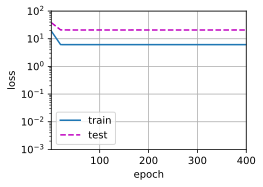

In [8]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### 高阶多项式函数拟合(过拟合)

weight: [[ 5.0122318e+00  1.2654479e+00 -3.3292577e+00  5.1606698e+00
  -2.5320551e-01  1.5361285e+00 -5.3128649e-02  2.0777811e-03
  -5.4952808e-02  2.1129295e-01  5.1563192e-02 -1.5676080e-01
  -6.3955903e-02 -8.6949959e-02  1.4104360e-01 -2.1497421e-01
  -2.1512339e-01  6.2694430e-02  2.0937628e-01  5.2085727e-02]]


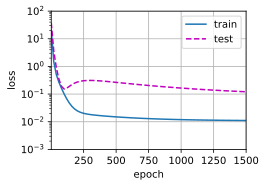

In [9]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)